In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import load_data
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score
import plot_learning_curve
from sklearn.model_selection import ShuffleSplit
from matplotlib import cm
import importlib

In [7]:
sites = ['sgp','goamazon']
feature_path = "/global/homes/z/zhangtao/ML_trigger/ML/data/"
feature_files = ["Arm_CF_1999_2009_hy.nc"]
cape_names = ['dilute_dcape','dilute_cape','undilute_dcape','undilute_cape']
cape_names_sh = ['dd','dc','udd','udc']
scam_dir="/global/homes/z/zhangtao/ML_trigger/calc_cape/scam_offline/"

In [8]:
dataset_all = {}
dataset_train_all = {}
dataset_test_all = {}

# load data

In [15]:
dmpdz = np.arange(0.25, 5.01, 0.25)
print(dmpdz)

[0.25 0.5  0.75 1.   1.25 1.5  1.75 2.   2.25 2.5  2.75 3.   3.25 3.5
 3.75 4.   4.25 4.5  4.75 5.  ]


In [17]:
# read features
dataset_all = {}
dataset_train_all = {}
dataset_test_all = {}

dmpdz_list = np.arange(0.25, 5.01, 0.25)
dmpdz_sen = {}
dmpdz_sen['sgp'] = np.zeros_like(dmpdz_list)
dmpdz_sen['goamazon'] = np.zeros_like(dmpdz_list)

for ii,dmpdz in enumerate(dmpdz_list):
    print(dmpdz)
    for site in sites:
        # load 4 cape triggers
        cape4s = {}
        for cape,cape_sh in zip(cape_names,cape_names_sh):
            cape4s[cape_sh] = np.loadtxt(scam_dir+site+"_"+cape+"_tiedke_0.5.txt")
            cape4s['dd'] = np.loadtxt(scam_dir+"entrainment/"+site+"_dilute_dcape_dmpdz_"+str(dmpdz)+".txt")

            if site == 'sgp':
                dataset = load_data.load_sgp_data(feature_path,"Arm_CF_1999_2009_hy.nc")
            elif site == 'goamazon':
                dataset = load_data.load_arm_hy(feature_path,"trigger_goamazon_hy.nc")

            dataset['cape'] = cape4s['dd']
            dataset.rename(columns={'cape':'ddcape'}, inplace=True)

            lcl = np.loadtxt(feature_path+site+"_dilute_lcl")
            dataset['lcl'] = lcl

            #if site == 'sgp':
            #    dataset = dataset.iloc[::3,:]
        dataset_all[site] = dataset


    for site in sites:
        dataset_x = dataset_all[site].iloc[:,:86+1]
        dataset_y = dataset_all[site].iloc[:,86]

        dataset_x_train, dataset_x_test, dataset_y_train, dataset_y_test=train_test_split(
            dataset_x, dataset_y, test_size=0.2, random_state=20)

        dataset_train_all[site] = dataset_x_train
        dataset_test_all[site] = dataset_x_test

    for n,site in enumerate(sites):
        dataset_train_x = dataset_train_all[site].iloc[:,:86]
        dataset_train_y = dataset_train_all[site].iloc[:,86]

        dataset_test_x = dataset_test_all[site].iloc[:,:86]
        dataset_test_y = dataset_test_all[site].iloc[:,86]

        xgb = XGBClassifier(n_estimators=600,silent=True, nthread=-1, max_depth=7,scale_pos_weight=3.5)
        xgb.fit(dataset_train_x, dataset_train_y)

        data_predic_y = xgb.predict(dataset_test_x)

        tn, fp, fn, tp = confusion_matrix(dataset_test_y, data_predic_y).ravel()
        f1 = f1_score(dataset_test_y, data_predic_y, average='macro')
        p  = precision_score(dataset_test_y, data_predic_y, average='macro')
        r  = recall_score(dataset_test_y, data_predic_y, average='macro')
        
        dmpdz_sen[site][ii] = f1

        print(site)
        print(tp,fp,fn,tn)
        print(f1,p,r)

0.25
sgp
355 43 67 4095
0.9263003232441962 0.9379308846008032 0.9154203670065215
goamazon
181 20 16 951
0.9454859436501393 0.94197574691177 0.9490922017701151
0.5
sgp
350 38 72 4100
0.9254802335428087 0.9424019728973718 0.9101003529877978
goamazon
174 19 23 952
0.9353624792473714 0.938982330277667 0.9318406373668885
0.75
sgp
353 41 69 4097
0.9259747251501758 0.9396882181352062 0.913292361399032
goamazon
171 18 26 953
0.931723130065099 0.9391020964054673 0.9247413572276213
1.0
sgp
345 44 77 4094
0.9181194785444274 0.9342143296935197 0.9034511944548159
goamazon
172 19 25 952
0.932005334575245 0.9374675119368512 0.9267644952349088
1.25
sgp
347 40 75 4098
0.9220060565777346 0.9393340726746509 0.9063041879791736
goamazon
169 23 28 948
0.921350228352102 0.9257599043715847 0.9170905498021298
1.5
sgp
346 47 76 4091
0.9171346996967604 0.9310842918826037 0.9042735346196047
goamazon
161 21 36 950
0.9102390040218256 0.924052114214386 0.8978158473916158
1.75
sgp
345 44 77 4094
0.9181194785444274 0.

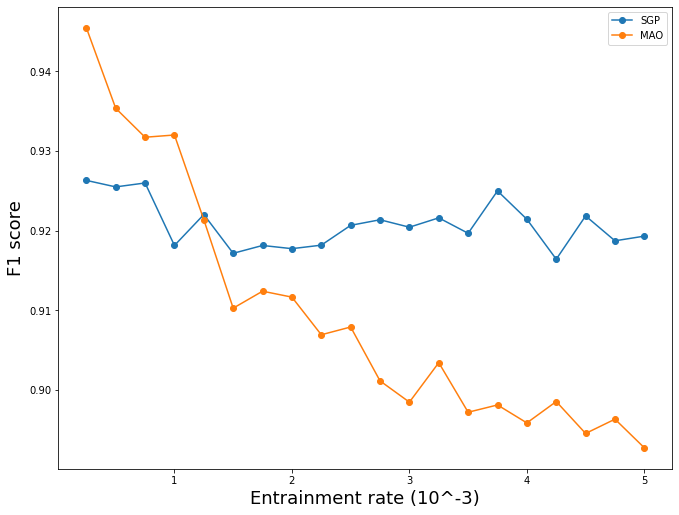

In [36]:
plt.figure(figsize=(11,8.5))
plt.plot(dmpdz_list,dmpdz_sen['sgp'],'-o',label='SGP')
plt.plot(dmpdz_list,dmpdz_sen['goamazon'],'-o',label='MAO')
plt.xlabel("Entrainment rate (10^-3)", fontsize=18)
plt.ylabel("F1 score", fontsize=18)

plt.legend()

In [12]:
# read features

for site in sites:
    # load 4 cape triggers
    cape4s = {}
    for cape,cape_sh in zip(cape_names,cape_names_sh):
        cape4s[cape_sh] = np.loadtxt(scam_dir+site+"_"+cape+"_tiedke_0.5.txt")
        cape4s['dd'] = np.loadtxt(scam_dir+"entrainment/"+site+"_dilute_dcape_dmpdz_1.0.txt")
        
        if site == 'sgp':
            dataset = load_data.load_sgp_data(feature_path,"Arm_CF_1999_2009_hy.nc")
        elif site == 'goamazon':
            dataset = load_data.load_arm_hy(feature_path,"trigger_goamazon_hy.nc")
            
        dataset['cape'] = cape4s['dd']
        dataset.rename(columns={'cape':'ddcape'}, inplace=True)
        
        lcl = np.loadtxt(feature_path+site+"_dilute_lcl")
        dataset['lcl'] = lcl
    
        #if site == 'sgp':
        #    dataset = dataset.iloc[::3,:]
    dataset_all[site] = dataset

# verify cape value

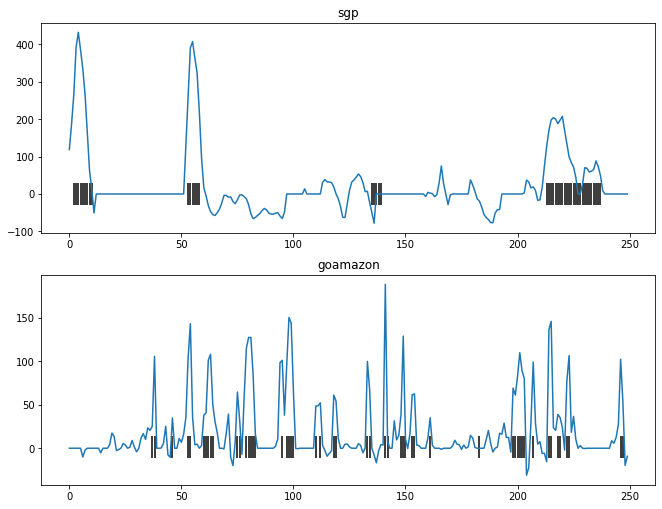

In [26]:
fig,axes = plt.subplots(2,1,figsize=(11,8.5),squeeze=False)

for n,site in enumerate(sites):
    dataset = dataset_all[site]
    n_sample = dataset.shape[0]
    real_trigger = np.zeros(n_sample)
    
    for i in range(n_sample):
        if dataset.loc[i,'PRECT'] > 0.5:
            real_trigger[i] = 1
        else:
            real_trigger[i] = np.nan
            
    axes[n][0].scatter(range(250),real_trigger[:250], color='k',marker='|',s=500)
    axes[n][0].plot(range(250), dataset.loc[:250-1,'ddcape'])
    axes[n][0].set_title(site)

# divide training and testing data

In [13]:
for site in sites:
    dataset_x = dataset_all[site].iloc[:,:86+1]
    dataset_y = dataset_all[site].iloc[:,86]
    
    dataset_x_train, dataset_x_test, dataset_y_train, dataset_y_test=train_test_split(
        dataset_x, dataset_y, test_size=0.2, random_state=20)
    
    dataset_train_all[site] = dataset_x_train
    dataset_test_all[site] = dataset_x_test

# performance of cape triggers

In [29]:
cape_thres = 65

for site in sites:
    print(site)
    
    dataset_test = dataset_test_all[site]
    real_trigger = dataset_test_all[site].iloc[:,86]
    
    n_test = dataset_test.shape[0]
    
    cape_trigger = np.zeros(n_test)
    for i in range(n_test):
        if dataset_test.iloc[i,4] > cape_thres:
            cape_trigger[i] = 1
            
    tn, fp, fn, tp = confusion_matrix(real_trigger, cape_trigger).ravel()
    f1 = f1_score(real_trigger, cape_trigger,average='macro')
    p  = precision_score(real_trigger, cape_trigger,average='macro')
    r  = recall_score(real_trigger, cape_trigger,average='macro')

    print(tp,fp,fn,tn)
    print(f1, p, r)
    

sgp
250 136 172 4002
0.7908785103726927 0.8032304594690547 0.779775471356678
goamazon
116 1 81 970
0.8491497980809819 0.9571917668968097 0.7939013105961199


# performance of xgb trigger

sgp
345 44 77 4094
0.9181194785444274 0.9342143296935197 0.9034511944548159
goamazon
172 19 25 952
0.932005334575245 0.9374675119368512 0.9267644952349088


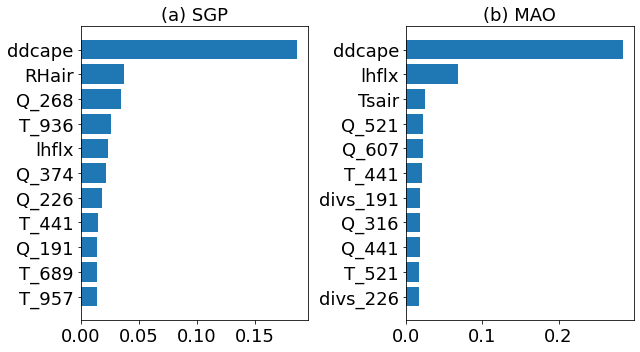

In [14]:
fig, axes = plt.subplots(1,2,figsize=(9,5), squeeze=False)
titles = ["(a) SGP", "(b) MAO"]
fh = 18

for n,site in enumerate(sites):
    dataset_train_x = dataset_train_all[site].iloc[:,:86]
    dataset_train_y = dataset_train_all[site].iloc[:,86]
    
    dataset_test_x = dataset_test_all[site].iloc[:,:86]
    dataset_test_y = dataset_test_all[site].iloc[:,86]
    
    xgb = XGBClassifier(n_estimators=600,silent=True, nthread=-1, max_depth=7,scale_pos_weight=3.5)
    xgb.fit(dataset_train_x, dataset_train_y)
    
    data_predic_y = xgb.predict(dataset_test_x)
    
    tn, fp, fn, tp = confusion_matrix(dataset_test_y, data_predic_y).ravel()
    f1 = f1_score(dataset_test_y, data_predic_y, average='macro')
    p  = precision_score(dataset_test_y, data_predic_y, average='macro')
    r  = recall_score(dataset_test_y, data_predic_y, average='macro')

    print(site)
    print(tp,fp,fn,tn)
    print(f1,p,r)
    
    #display importance
    importance = xgb.feature_importances_
    name = dataset_all[site].columns.values.tolist()[:86]
    imp = pd.DataFrame({"imp":importance, "name":name})
    imp.sort_values('imp',inplace=True,ascending=False)
    imp.reset_index(inplace=True)
    axes[0][n].invert_yaxis()
    axes[0][n].barh(imp.loc[:10,'name'],imp.loc[:10,'imp'])
    axes[0][n].set_title(titles[n],fontsize=fh)
    axes[0][n].tick_params(labelsize=fh)
    
plt.tight_layout()
plt.savefig("figs/imp.pdf")

# XGB learning curve

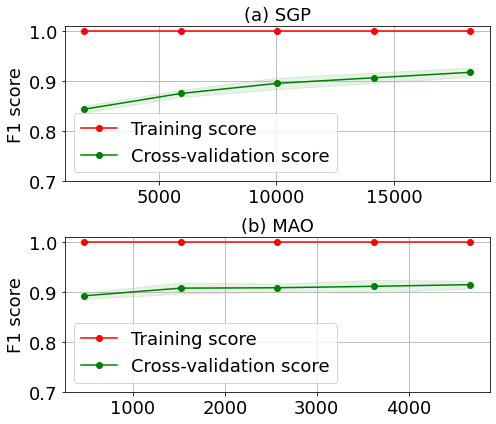

In [48]:
importlib.reload(plot_learning_curve)

fh = 18
titles = ['(a) SGP','(b) MAO']
fig, axes = plt.subplots(2,1,figsize=(7,6),squeeze=False)

for n,site in enumerate(sites):

    dataset_x = dataset_all[site].iloc[:,:86]
    dataset_y = dataset_all[site].iloc[:,86]

    xgb = XGBClassifier(n_estimators=600,silent=True, nthread=10, max_depth=7,scale_pos_weight=3.5)
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=10)
    ax = plot_learning_curve.plot_learning_curve(axes[n][0],xgb,dataset_x, dataset_y, ylim=(0.7, 1.01), cv=cv, n_jobs=-1)

    axes[n][0].set_xlabel("")
    axes[n][0].tick_params(labelsize=fh)
    axes[n][0].set_title(titles[n], fontsize=fh)
    axes[n][0].set_ylabel('F1 score', fontsize=fh)
    axes[n][0].legend(fontsize=fh)
    axes[n][0].legend(fontsize=fh, loc='lower left')
    
plt.tight_layout()

# performance compare

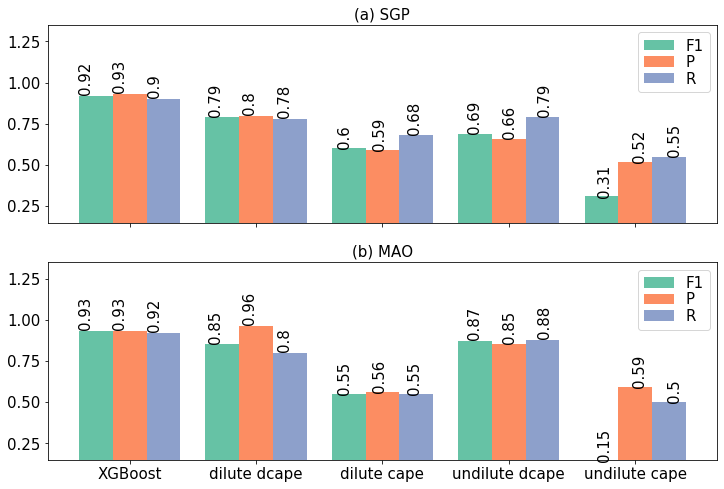

In [17]:
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(12,8))
fh = 15
sites = ["SGP", "MAO"]

palette = plt.get_cmap('Set2')

for site,n in zip(sites, range(2)):
    perf = pd.read_excel("dmpdz.xlsx", sheet_name=site, index_col='name')
    perf.iloc[:,4:].plot.bar(ax=axes[n], width = .8, color=[palette(0),palette(1),palette(2)])
    axes[n].set_title(titles[n], fontsize=fh)
    axes[n].legend(loc=1,fontsize=fh,labelspacing=0.1)
    axes[n].set_ylim(0.15,1.35)

    for p in axes[n].patches:
        axes[n].annotate(str(p.get_height()), (p.get_x() * 1.028, p.get_height() * 1.028), rotation=90, size=fh)
        
    axes[n].tick_params(labelsize=fh)
    
plt.xlabel("")
plt.xticks(rotation=0)
plt.savefig("figs/perf.pdf")

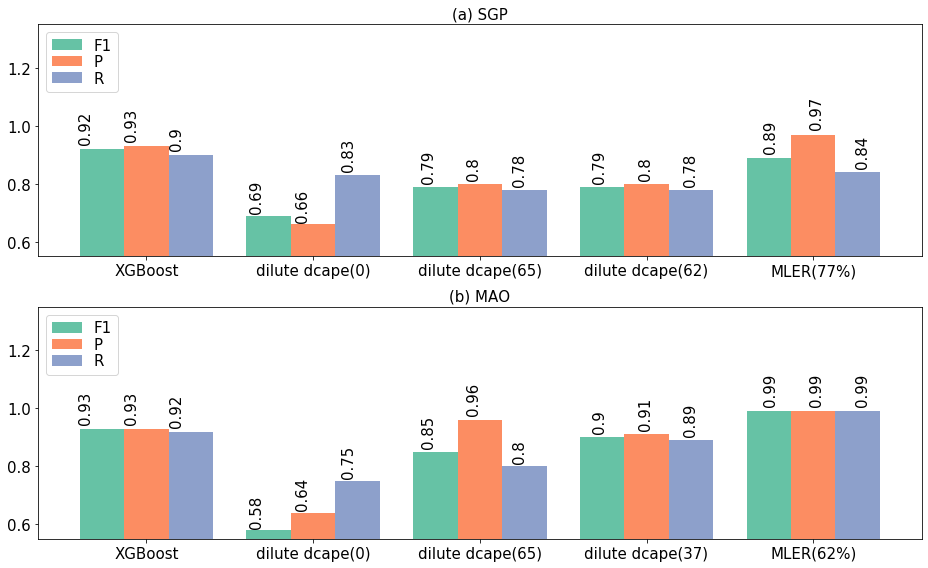

In [38]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(13,8))
fh = 15
sites = ["SGP_dt", "MAO_dt"]
titles = ["(a) SGP", "(b) MAO"]

palette = plt.get_cmap('Set2')

for site,n in zip(sites, range(2)):
    perf = pd.read_excel("dmpdz.xlsx", sheet_name=site, index_col='name')
    perf.iloc[:,4:].plot.bar(ax=axes[n], width = .8, color=[palette(0),palette(1),palette(2)])
    axes[n].set_title(titles[n], fontsize=fh)
    axes[n].legend(loc=2,fontsize=fh,labelspacing=0.1)
    axes[n].set_ylim(0.55,1.35)
    axes[n].tick_params(axis='x', rotation=0)
    axes[n].set_xlabel("")

    for p in axes[n].patches:
        axes[n].annotate(str(p.get_height()), (p.get_x() * 1.028, p.get_height() * 1.028), rotation=90, size=fh)
        
    axes[n].tick_params(labelsize=fh)
    
plt.tight_layout()
#plt.xticks(rotation=0)
plt.savefig("figs/perf_dt.pdf")

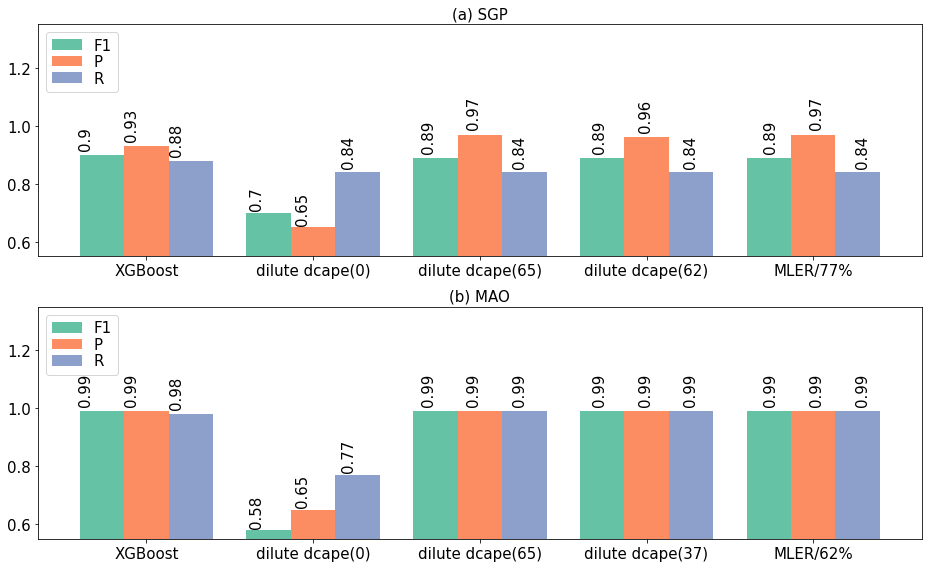

In [5]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(13,8))
fh = 15
sites = ["SGP_dt_1", "MAO_dt_1"]
titles = ["(a) SGP", "(b) MAO"]

palette = plt.get_cmap('Set2')

for site,n in zip(sites, range(2)):
    perf = pd.read_excel("dmpdz.xlsx", sheet_name=site, index_col='name')
    perf.iloc[:,4:].plot.bar(ax=axes[n], width = .8, color=[palette(0),palette(1),palette(2)])
    axes[n].set_title(titles[n], fontsize=fh)
    axes[n].legend(loc=2,fontsize=fh,labelspacing=0.1)
    axes[n].set_ylim(0.55,1.35)
    axes[n].tick_params(axis='x', rotation=0)
    axes[n].set_xlabel("")

    for p in axes[n].patches:
        axes[n].annotate(str(p.get_height()), (p.get_x() * 1.028, p.get_height() * 1.028), rotation=90, size=fh)
        
    axes[n].tick_params(labelsize=fh)
    
plt.tight_layout()
#plt.xticks(rotation=0)
plt.savefig("figs/perf_dt_1.pdf")

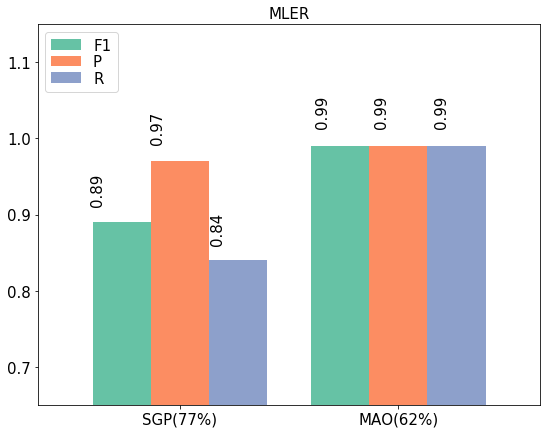

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(9,7))
fh = 15
sites = ["SGP_dt_1", "MAO_dt_1"]
titles = ["(a) SGP", "(b) MAO"]

palette = plt.get_cmap('Set2')

perf = pd.read_excel("dmpdz.xlsx", sheet_name='dt', index_col='name')
perf.iloc[:,4:].plot.bar(ax=axes, width = .8, color=[palette(0),palette(1),palette(2)])
axes.set_title("MLER", fontsize=fh)
axes.legend(loc=2,fontsize=fh,labelspacing=0.1)
axes.set_ylim(0.65,1.15)
axes.tick_params(axis='x', rotation=0)
axes.set_xlabel("")

for p in axes.patches:
    axes.annotate(str(p.get_height()), (p.get_x() * 1.028, p.get_height() * 1.028), rotation=90, size=fh)
        
axes.tick_params(labelsize=fh)
plt.savefig("figs/MLER_1.pdf")


# diurnal cycle

In [ ]:
shapes = {"sgp":sgp_trig_x.shape[0], "mao":mao_trig_x.shape[0]}
trig_xs = {"sgp":sgp_trig_x, "mao":mao_trig_x}


for site,n in zip(sites,range(2)):
    print(site)
    sl = shapes[site][0]
    train_len = int(sl * 3 / 4)
    ts_x_train = trig_xs[site].iloc[:train_len,:]
ts_y_train = trig_y.iloc[:train_len]
ts_x_test  = trig_x.iloc[train_len:,:]
ts_y_test  = trig_y.iloc[train_len:].tolist()
prect_test = dataset['PRECT'].iloc[train_len:]
hour_test  = dataset['hour'].iloc[train_len:]
day_test  = dataset['day'].iloc[train_len:]
mon_test  = dataset['mon'].iloc[train_len:]
year_test = dataset['year'].iloc[train_len:]

#print(year_test)
#print(mon_test)
#print(day_test)
#print(hour_test)
xgb.fit(ts_x_train, ts_y_train)
ts_y_pred = xgb.predict(ts_x_test)

print(ts_x_test.shape)

for i in range(ts_x_test.shape[0]):
    if ts_y_pred[i] == 0:
        ts_y_pred[i] = np.nan
    if ts_y_test[i] == 0:
        ts_y_test[i] = np.nan

# Joint

## SGP train, MAO test

In [24]:
xgb = XGBClassifier(n_estimators=600,silent=True, nthread=-1, max_depth=7,scale_pos_weight=3.5)

xgb.fit(sgp_trig_x,sgp_trig_y)
y_pred_amazon = xgb.predict(mao_trig_x_test)
tn, fp, fn, tp = confusion_matrix(mao_trig_y_test, y_pred_amazon).ravel()
f1 = f1_score(mao_trig_y_test, y_pred_amazon,average='macro')
P  = precision_score(mao_trig_y_test, y_pred_amazon,average='macro')
R  = recall_score(mao_trig_y_test, y_pred_amazon,average='macro')
print(tp,fp,fn,tn)
print(f1,P,R)


121 538 76 433
0.43392270775448344 0.5171495777074868 0.5300726134028972


## MAO train, SGP test

In [25]:
xgb = XGBClassifier(n_estimators=600,silent=True, nthread=-1, max_depth=7,scale_pos_weight=3.5)

xgb.fit(mao_trig_x,mao_trig_y)
y_pred_sgp = xgb.predict(sgp_trig_x_test)
tn, fp, fn, tp = confusion_matrix(sgp_trig_y_test, y_pred_sgp).ravel()
f1 = f1_score(sgp_trig_y_test, y_pred_sgp,average='macro')
P  = precision_score(sgp_trig_y_test, y_pred_sgp,average='macro')
R  = recall_score(sgp_trig_y_test, y_pred_sgp,average='macro')
print(tp,fp,fn,tn)
print(f1,P,R)

321 353 101 3785
0.7645930820676656 0.7251351958105716 0.8376782977787653


## Joint train, Joint test

In [26]:
joint = pd.concat([sgp_dataset,mao_dataset])

x_joint = joint.iloc[:,0:86]
y_joint = joint.iloc[:,86]
x_train_joint,x_test_joint,y_train_joint,y_test_joint= train_test_split(x_joint, y_joint, test_size=0.2, random_state=20)

xgb = XGBClassifier(n_estimators=600,silent=True, nthread=-1, max_depth=7,scale_pos_weight=3.5)

xgb.fit(x_train_joint,y_train_joint)
y_pred_joint = xgb.predict(x_test_joint)
tn, fp, fn, tp = confusion_matrix(y_test_joint, y_pred_joint).ravel()
f1 = f1_score(y_test_joint, y_pred_joint,average='macro')
P  = precision_score(y_test_joint, y_pred_joint,average='macro')
R  = recall_score(y_test_joint, y_pred_joint,average='macro')
print(tp,fp,fn,tn)
print(f1,P,R)

474 60 112 5082
0.9148938522777532 0.9330385535600714 0.8986025543506397


## Joint train, SGP test

In [27]:

x_joint_train = np.concatenate((sgp_trig_x_train, mao_trig_x_train), axis=0)
y_joint_train = np.concatenate((sgp_trig_y_train, mao_trig_y_train), axis=0)
xgb.fit(x_joint_train, y_joint_train)

y_pred_sgp = xgb.predict(sgp_trig_x_test.values)
tn, fp, fn, tp = confusion_matrix(sgp_trig_y_test, y_pred_sgp).ravel()
f1 = f1_score(sgp_trig_y_test, y_pred_sgp,average='macro')
P = precision_score(sgp_trig_y_test, y_pred_sgp,average='macro')
R = recall_score(sgp_trig_y_test, y_pred_sgp,average='macro')
print(tp,fp,fn,tn)
print(f1,P,R)

343 47 79 4091
0.9148307406239105 0.9302711676812396 0.9007190322499364


## Joint train, MAO test

In [28]:
x_joint_train = np.concatenate((sgp_trig_x_train, mao_trig_x_train), axis=0)
y_joint_train = np.concatenate((sgp_trig_y_train, mao_trig_y_train), axis=0)
xgb.fit(x_joint_train, y_joint_train)

y_pred_mao = xgb.predict(mao_trig_x_test.values)
tn, fp, fn, tp = confusion_matrix(mao_trig_y_test, y_pred_mao).ravel()
f1 = f1_score(mao_trig_y_test, y_pred_mao,average='macro')
P = precision_score(mao_trig_y_test, y_pred_mao,average='macro')
R = recall_score(mao_trig_y_test, y_pred_mao,average='macro')
print(tp,fp,fn,tn)
print(f1,P,R)

173 22 24 949
0.9294952548920802 0.9312567528394866 0.9277577671247915


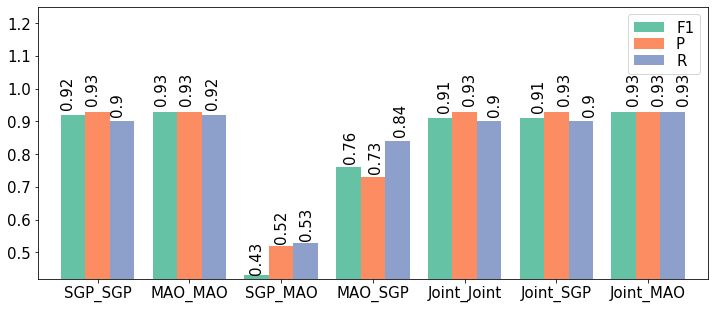

In [37]:
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(12,5))
fh = 15
perf = pd.read_excel("dmpdz.xlsx", sheet_name="joint", index_col='name')

palette = plt.get_cmap('Set2')
perf.iloc[:,4:].plot.bar(ax=axes, width = .8, color=[palette(0),palette(1),palette(2)])
axes.legend(loc=1,fontsize=fh,labelspacing=0.1)
axes.set_ylim(0.42,1.25)

for p in axes.patches:
        axes.annotate(str(p.get_height()), (p.get_x() * 1.028, p.get_height() * 1.028), rotation=90, size=fh)
        
axes.tick_params(labelsize=fh)
    
plt.xlabel("")
plt.xticks(rotation=0)
plt.savefig("figs/joint.pdf")


In [20]:
a = 1373
b = 644
c = 1337
d = 26886
n = a+b+c+d

a = 42
b = 109
c = 155
d = 862
n = a+b+c+d


hss = 2*(a*d - b*c)/((a+c)*(c+d) + (a+b)*(b+d))
ets = (a-(a+b)*(a+c)/n)/(a+b+c-(a+b)*(a+c)/n)

print(a/n, b/n, c/n, d/n)
print(ets, hss)

0.03595890410958904 0.09332191780821918 0.1327054794520548 0.738013698630137
0.058929808552131625 0.11130068882035911


In [ ]:
dilute_dcape: 0.7
dilute_cape: 0.11
undilute_dcape: 0.73